## forest fire model

In [2]:
from IPython.display import HTML

import matplotlib.pyplot as plt
import numpy as np
import tqdm
import pandas as pd 

from modules.forest import Forest, plot_state, animate
from modules.plots import setup_mpl
%load_ext autoreload
%autoreload 2

setup_mpl(as_default=0)

# Percolation
- 火灾的破坏力
    - 总面积
- 持续时间
    - 假设每棵树燃烧一段时间，也即step

In [34]:
## 首先实现一个模型
f = Forest(n_x=100, n_y=100)
f.init_trees(tree_fraction=0.4,rnd_seed=3)
f.ignite(rnd_seed=23)

STEP = 1
ls_tofire = f.get_tofire()
while len(ls_tofire) > 0:
    f.iterate_perco(ls_tofire)
    ls_tofire = f.get_tofire()
    # print(STEP, ls_tofire)
    STEP += 1

## plot 
fig,ax = plt.subplots(1,2,figsize=(11, 6.25), dpi=200)
plot_state(f.initstate,ax[0],title="Begin")
plot_state(f.state,ax[1],title="End")
fig.tight_layout()
plt.savefig("results/forest_fire.jpg",dpi=200)
plt.close()

## animate
anim = animate(f, steps=STEP)
with open("results/forest_fire.html", "w", encoding="utf-8") as x:
    print(anim.to_jshtml(), file=x)

In [45]:
def fire_fraction(f):
    """计算火灾破坏的比例"""
    return len(np.where(f.state==2)[0])/len(np.where(f.state>0)[0])

### 临界状态过程绘制

Animation size has reached 21000294 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


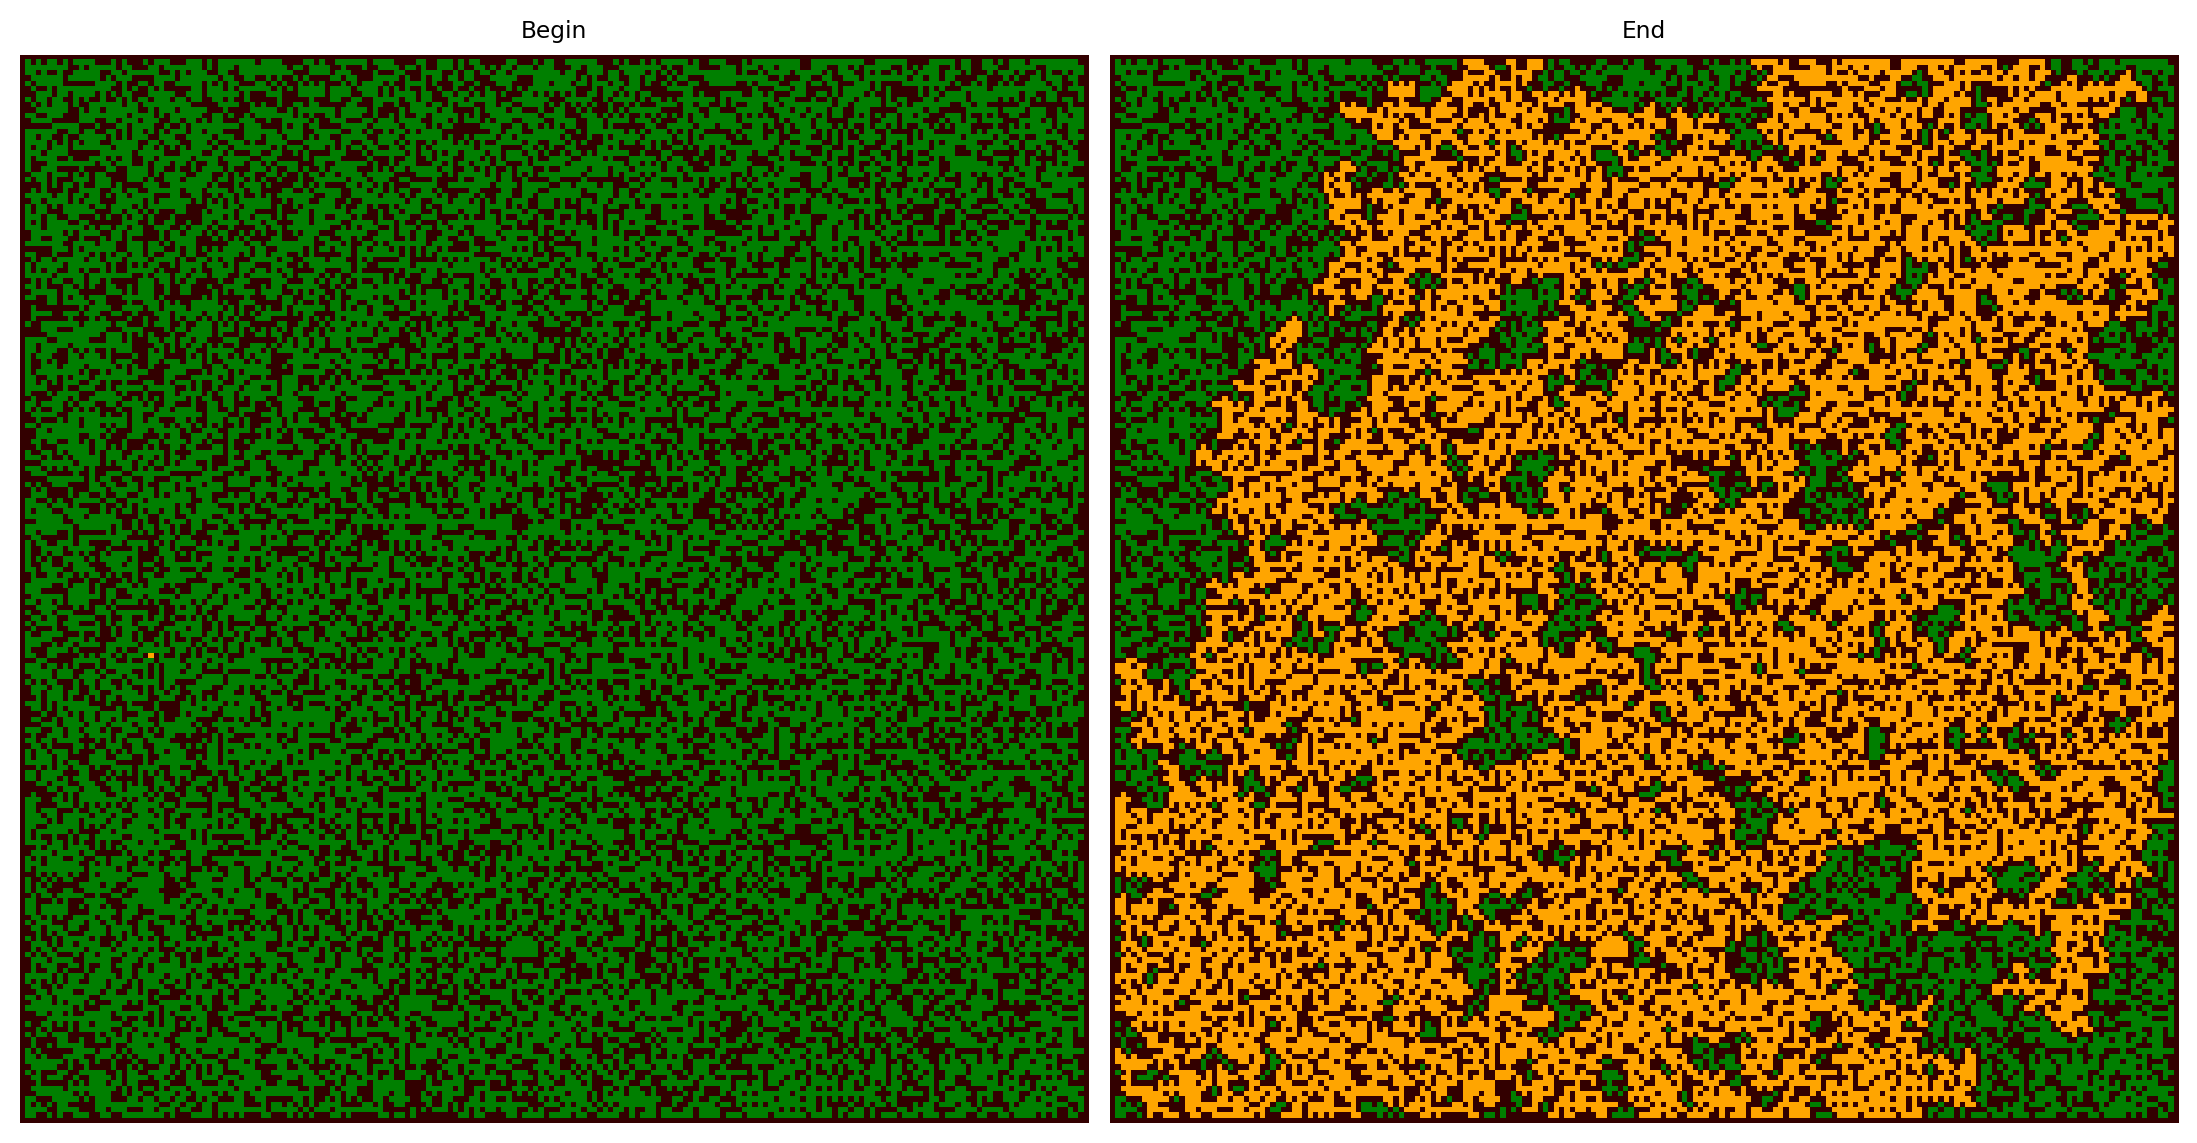

In [189]:
## 绘制邻接状态的渗流过程
f = Forest(n_x=200, n_y=200)
f.init_trees(tree_fraction=0.605,rnd_seed=None)
f.ignite(rnd_seed=None)

STEP = 1
ls_tofire = f.get_tofire(neighbor=Forest.neighbourhood_4)
while len(ls_tofire) > 0:
    f.iterate_perco(ls_tofire)
    ls_tofire = f.get_tofire(neighbor=Forest.neighbourhood_4)
    # print(STEP, ls_tofire)
    STEP += 1
ff = fire_fraction(f)

## plot 
fig,ax = plt.subplots(1,2,figsize=(11, 6.25), dpi=200)
plot_state(f.initstate,ax[0],title="Begin")
plot_state(f.state,ax[1],title="End")
fig.tight_layout()

## animate
anim = animate(f, steps=STEP,neighbor=Forest.neighbourhood_4)
with open("results/forest_fire.html", "w", encoding="utf-8") as x:
    print(anim.to_jshtml(), file=x)


### parameter senstive analysis 

In [115]:
## 参数敏感性实验
arr_tf = np.linspace(0.01,0.99,30) # tree fraction 

arr_result = []
for nx in [50,100,150,200]:
    for ny in [50,100,150,200]:
        for tf in tqdm.tqdm(arr_tf):
            for n in range(2): # neighbour type
                neighbor = [Forest.neighbourhood_8,Forest.neighbourhood_4][n]
                for k in range(10): # repeat times
                    f = Forest(n_x=nx, n_y=ny)
                    f.init_trees(tree_fraction=tf,rnd_seed=None)
                    f.ignite(rnd_seed=None)

                    STEP = 1
                    ls_tofire = f.get_tofire(neighbor=neighbor)
                    while len(ls_tofire) > 0:
                        f.iterate_perco(ls_tofire)
                        ls_tofire = f.get_tofire(neighbor=neighbor)
                        # print(STEP, ls_tofire)
                        STEP += 1
                    ff = fire_fraction(f)

                    arr_result.append({"nx":nx,"ny":ny,"tree_frac":tf,"neighbor":n,"repeat":k,"fire_fraction":ff,"STEP":STEP})

100%|██████████| 30/30 [50:29<00:00, 100.99s/it]


In [176]:
# 保存结果
df_result = pd.DataFrame(data=arr_result)

save = 0
if save:
    df_result.to_excel('results/forest_fire.xlsx',index=False)

In [4]:
df_result = pd.read_excel('results/forest_fire.xlsx')
df_resmean = df_result.groupby(['nx', 'ny', 'tree_frac', "neighbor"], as_index=False)[
    ['fire_fraction', 'STEP']].mean()


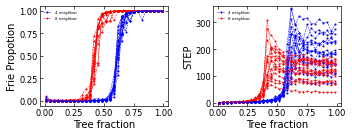

In [7]:
# 绘制参数敏感性图
fig,ax = plt.subplots(1,2,figsize=(5,2))

for nx in [50,100,150,200]:
    for ny in [50,100,150,200]:
        df_8 = df_resmean[(df_resmean["nx"]==nx) & (df_resmean["ny"]==ny) & (df_resmean['neighbor']==0)]
        df_4 = df_resmean[(df_resmean["nx"]==nx) & (df_resmean["ny"]==ny) & (df_resmean['neighbor']==1)]
        nei8, = ax[0].plot(df_8["tree_frac"], df_8["fire_fraction"], 
            'r--', marker='.', ms=2, lw=0.5 )
        nei4, = ax[0].plot(df_4["tree_frac"], df_4["fire_fraction"], 
            'b--', marker='.', ms=2, lw=0.5)
        ax[0].set_xlabel("Tree fraction")
        ax[0].set_ylabel("Frie Propotion")
        ax[0].set_ylim(-0.05,1.05)
        ax[0].legend([nei4,nei8],["4 neighbor","8 neighbor"],frameon=False,fontsize=4)

        nei8, = ax[1].plot(df_8["tree_frac"], df_8["STEP"], 
            'r--', marker='.', ms=2, lw=0.5 )
        nei4, = ax[1].plot(df_4["tree_frac"], df_4["STEP"], 
            'b--', marker='.', ms=2, lw=0.5)
        ax[1].set_xlabel("Tree fraction")
        ax[1].set_ylabel("STEP")
        ax[1].set_ylim(-10,360)
        ax[1].legend([nei4,nei8],["4 neighbor","8 neighbor"],frameon=False,fontsize=4,loc="upper left")

save = 1
if save:
    plt.savefig('results/para_sens.jpg',dpi=300)

(0.0, 150.0)

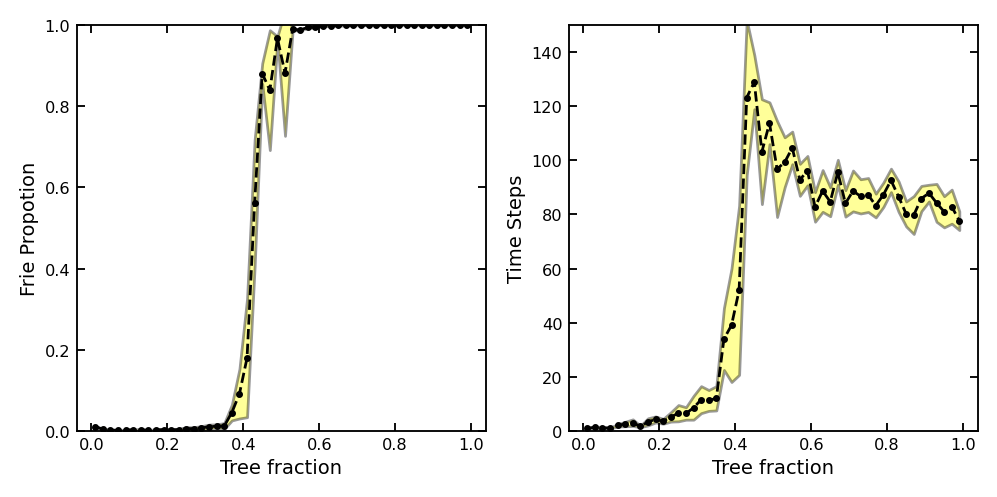

In [113]:
df_resmean = df_result.groupby(['nx','ny','tree_frac',"neighbor"],as_index=False)[['fire_fraction','STEP']].mean()
df_resstd = df_result.groupby(['nx','ny','tree_frac',"neighbor"],as_index=False)[['fire_fraction','STEP']].std()

fig,ax = plt.subplots(1,2,figsize=(5,2.5),dpi=200)
ax[0].plot(df_resmean["tree_frac"],
           df_resmean["fire_fraction"], 'k--', marker='.', ms=3)
ax[0].set_xlabel("Tree fraction")
ax[0].set_ylabel("Frie Propotion")
ax[0].set_ylim(0,1)

ax[1].plot(df_resmean["tree_frac"],df_resmean["STEP"], 'k--', marker='.',ms=3)
ax[1].set_xlabel("Tree fraction")
ax[1].set_ylabel("Time Steps")
ax[1].set_ylim(0,150)